# EMG data exploration from the Myo Armband

Collecting both "resting" data and "gesture" data from the armband. Hoping implement a training pipeline for the end user, in case the default classifier doesn't do it for them. 

I'm going to try to keep this notebook as "candid" as possible. I'd be interested in coming back to this in the future and (hopefully) seeing how I've improved.

First, let's import some data. I've saved an array of EMG data as numpy arrays.

Oh, actually, I don't know how to read numpy files... Quick google search leads me to `NPZ.jl`. Thanks `fhs`!

In [1]:
using Pkg

In [2]:
# Pkg.add("NPZ")

In [3]:
using NPZ

Let's save them:

In [4]:
gesture_peace = npzread("peace/peacedata.npy")
rest_peace = npzread("peace/restdata-peace.npy")

gesture_fist = npzread("fist/fistdata.npy")
rest_fist = npzread("fist/restdata-fist.npy")

gesture_thumbup = npzread("thumbup/thumbupdata.npy")
rest_thumbup = npzread("thumbup/restdata-thumbup.npy")

393×8 Array{Int64,2}:
  21   26   24   34   54  34   38  25
  19   24   24   32   44  30   34  24
  20   23   26   33   44  26   30  23
  19   21   26   38   54  21   29  24
  18   22   28   43   54  23   28  23
  19   20   28   43   48  21   26  23
  18   22   30   55   69  26   29  21
  20   23   30   72   80  30   31  23
  20   24   29   89   78  31   28  20
  21   23   29   92   82  30   27  22
  22   24   38  100   92  36   29  23
  27   35   49  110   84  36   26  23
  45   54   61  109   77  33   23  24
   ⋮                       ⋮         
  23   20   24   44   49  24   24  21
  23   19   23   44   52  22   23  22
  22   20   25   55   69  27   24  23
  22   23   25   84   77  30   22  21
  22   23   27   91   80  30   23  21
  22   30   31  154   93  34   24  21
  29   55   54  179  115  41   28  23
  43  105   68  205  130  46   31  26
  50  135   71  227  132  52   37  34
  75  204   97  241  159  67   57  52
 116  270  141  235  162  82  135  85
 127  305  167  240  149  99

There are 8 sensors on the myo armband, corresponding to the 8-array in each element. I guess Julia is going to store this as an array, which is fine. I may possible have to transpose them though? Since they're small and few, it's not such a big deal.

Let's see if I can try to plot them... Maybe using an SVD esque thing to knock the dimensions down to two by selecting the two most principal components... or something. It's been a while!

Julia has SVD in the linear algebra standard lib. nice!

In [5]:
using LinearAlgebra

Ah, the coding begins. If I'm too candid, the document is going to be way too messy. I'll try to keep the notes here, but I will do a bunch of rough work (read: mess around until I get the syntax right.. lol) inside of a separate console window.

The first result for "SVD dimensionality reduction" is from an Oracle blog post. It's a fairly nice refresher!

Now, the $S$ in our SVD object is the $\Sigma$ matrix: the diagonal matrix of "eigenvalues" (actually, singular values). Here's the diagonal values:

In [6]:
peace_svd = svd(gesture_peace)

SVD{Float64,Float64,Array{Float64,2}}([-0.0705804 0.203959 … -0.0779953 -0.0346056; -0.0753079 0.205416 … -0.118551 0.0333529; … ; -0.0397112 0.0238801 … 0.0536535 -0.0255659; -0.0380523 0.0381473 … 0.0382011 -0.000719594], [10063.2, 873.216, 675.663, 589.332, 478.837, 275.54, 222.398, 133.006], [-0.152962 -0.125863 … -0.253651 -0.199835; -0.100578 0.237971 … -0.563141 -0.392197; … ; -0.0557154 0.392701 … 0.0388866 -0.0135447; 0.014592 0.00117237 … -0.100131 -0.035158])

In [7]:
peace_svd.S

8-element Array{Float64,1}:
 10063.20322504623   
   873.216249610074  
   675.6625374099833 
   589.3316481860738 
   478.83729619618947
   275.5397758239695 
   222.3977464404512 
   133.0056198497727 

Looks like a lot of these components are fairly important. For the sake of visualization, we'll keep two.

My linear algebra is really, really rusty. But it seems that the principal components of our matrix $M$ are given by $T = MW$ where $W$ is a "weight matrix" that also happens to have its column be the eigenvectors of $M^T M$, which I swear has an actual name..

If we decompose $M$ via SVD, i.e., $M = U \Sigma V^T$  then we can use $T = U \Sigma$. We truncate to using the two singular vectors and two singular values, for purposes of a 2d plot

In [8]:
Ul = peace_svd.U[:, 1:2]
Σl = Diagonal(peace_svd.S[1:2])

2×2 Diagonal{Float64,Array{Float64,1}}:
 10063.2     ⋅   
      ⋅   873.216

In [9]:
Tl = Ul * Σl

300×2 Array{Float64,2}:
  -710.265  178.1    
  -757.839  179.372  
  -781.997  188.764  
  -857.441  192.82   
  -913.51   128.416  
 -1035.63   138.391  
 -1016.14    70.0414 
 -1135.2     59.9369 
 -1085.24   -22.2231 
 -1027.26   -70.5986 
  -975.88   -96.5997 
  -959.291  -68.5071 
  -840.902  -84.7623 
     ⋮               
  -434.842  -13.3831 
  -408.377    6.05243
  -411.491   14.6447 
  -411.911   23.0153 
  -378.298   17.6998 
  -378.012   32.1849 
  -411.228   18.8347 
  -414.048   18.6922 
  -357.548   12.6693 
  -398.742   12.1    
  -399.622   20.8525 
  -382.928   33.3108 

Let's try and make a function to do this for us....

In [10]:
function svdDimensionReduction(dat, numDims)
    dat_svd = svd(dat)
    return dat_svd.U[:, 1:numDims] * Diagonal(dat_svd.S[1:numDims])
end

svdDimensionReduction (generic function with 1 method)

In [11]:
# check if we get the same thing
svdDimensionReduction(gesture_peace, 2)

300×2 Array{Float64,2}:
  -710.265  178.1    
  -757.839  179.372  
  -781.997  188.764  
  -857.441  192.82   
  -913.51   128.416  
 -1035.63   138.391  
 -1016.14    70.0414 
 -1135.2     59.9369 
 -1085.24   -22.2231 
 -1027.26   -70.5986 
  -975.88   -96.5997 
  -959.291  -68.5071 
  -840.902  -84.7623 
     ⋮               
  -434.842  -13.3831 
  -408.377    6.05243
  -411.491   14.6447 
  -411.911   23.0153 
  -378.298   17.6998 
  -378.012   32.1849 
  -411.228   18.8347 
  -414.048   18.6922 
  -357.548   12.6693 
  -398.742   12.1    
  -399.622   20.8525 
  -382.928   33.3108 

Cool, looks like we have something. Let's gather the reduced datasets

In [12]:
reduced_gesture_peace = svdDimensionReduction(gesture_peace, 2)
reduced_gesture_fist = svdDimensionReduction(gesture_fist, 2)
reduced_gesture_thumbup = svdDimensionReduction(gesture_thumbup, 2)

reduced_rest_peace = svdDimensionReduction(rest_peace, 2)
reduced_rest_fist = svdDimensionReduction(rest_fist, 2)
reduced_rest_thumbup = svdDimensionReduction(rest_thumbup, 2)

393×2 Array{Float64,2}:
  -71.958    54.1055
  -66.467    45.7549
  -67.0196   42.3246
  -70.182    46.3791
  -73.9637   46.9302
  -71.7393   42.363 
  -84.6341   56.7798
  -96.9352   69.1012
 -103.082    72.8745
 -105.385    75.1512
 -119.786    79.1493
 -134.209    75.2951
 -149.173    71.5956
    ⋮               
  -70.1288   45.6365
  -69.5415   46.7385
  -80.9983   58.6218
  -96.8311   71.6038
 -102.405    74.0151
 -140.14     99.422 
 -183.564   116.11  
 -226.904   145.145 
 -252.151   167.2   
 -315.359   208.752 
 -391.854   239.27  
 -432.276   249.068 

Plot them... is it still plots.jl??? idk

In [13]:
using Plots

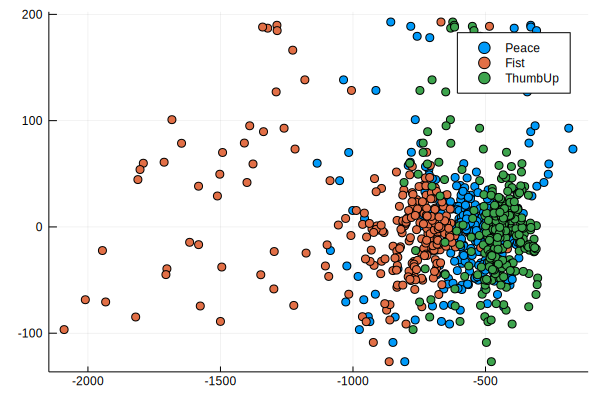

In [14]:
# plot the gestures

scatter(reduced_gesture_peace[:,1], reduced_gesture_peace[:,2],
            label = "Peace")
scatter!(reduced_gesture_fist[:,1], reduced_gesture_peace[:,2],
            label = "Fist")
scatter!(reduced_gesture_thumbup[:,1], reduced_gesture_peace[:,2],
            label = "ThumbUp")



Looks like we do have some clustering, although it is a bit tight.. it might be that more components will yield more separated sets. But let's see how the resting sets do.

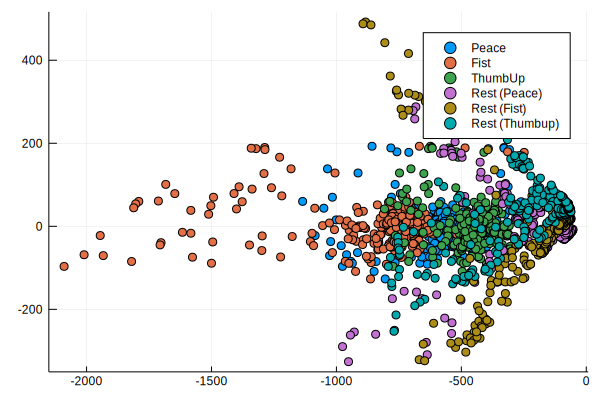

In [15]:

scatter(reduced_gesture_peace[:,1], reduced_gesture_peace[:,2],
            label = "Peace")
scatter!(reduced_gesture_fist[:,1], reduced_gesture_peace[:,2],
            label = "Fist")
scatter!(reduced_gesture_thumbup[:,1], reduced_gesture_peace[:,2],
            label = "ThumbUp")

scatter!(reduced_rest_peace[:,1], reduced_rest_peace[:,2],
            label = "Rest (Peace)")
scatter!(reduced_rest_fist[:,1], reduced_rest_fist[:,2],
            label = "Rest (Fist)")
scatter!(reduced_rest_thumbup[:,1], reduced_rest_thumbup[:,2],
            label = "Rest (Thumbup)")

At this point it's a bit crowded. I do think that the resting positions are fairly close together, but there's a lot of variance. Maybe some 3d plots?

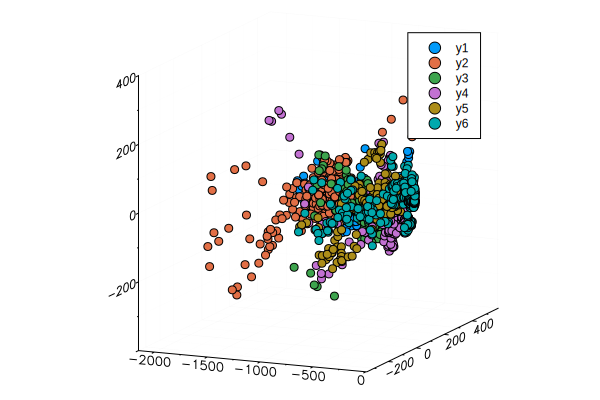

In [16]:
legend_names = ["Peace", "Fist", "ThumbUp", "Rest (Peace)", "Rest (Fist)", "Rest (ThumbUp)"]

og_datas = [gesture_peace,
                    gesture_fist,
                    gesture_thumbup,
                    rest_peace,
                    rest_fist,
                    rest_thumbup]

numDims = 3
# create the reduced datasets
reduced3D = map(x -> svdDimensionReduction(x, numDims), og_datas)

fig3D = scatter([reduced3D[1][:,k] for k in 1:numDims]...)

for j = 2:length(reduced3D)
    scatter!([reduced3D[j][:,k] for k in 1:numDims]...)
end

fig3D

need me some interactivity...

In [17]:
using PlotlyJS

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-10623908000462258229\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-17447844096593552723\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-10623908000462258229\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [18]:
#Pkg.add("InspectDR")

allllllright thats ugly too. I read the github page for plotlyjs, need blink for some reason.

In [19]:
#Pkg.add("Blink")
using Blink

In [20]:
plotlyjs()

Plots.PlotlyJSBackend()

In [21]:
legend_names = ["Peace", "Fist", "ThumbUp", "Rest (Peace)", "Rest (Fist)", "Rest (ThumbUp)"]

og_datas = [gesture_peace,
                    gesture_fist,
                    gesture_thumbup,
                    rest_peace,
                    rest_fist,
                    rest_thumbup]

numDims = 3
# create the reduced datasets
reduced3D = map(x -> svdDimensionReduction(x, numDims), og_datas)

fig3D = scatter([reduced3D[1][:,k] for k in 1:numDims]..., label = legend_names[1])

for j = 2:length(reduced3D)
    scatter!([reduced3D[j][:,k] for k in 1:numDims]..., label = legend_names[j])
end

fig3D

<!DOCTYPE html>
 
 
 Plots.jl

Looks like it could be workable with enough dimensions, without some sort of neural network. Maybe an SVM? K means?

right, first I'll need to parition off some testing and training data sets..

In [22]:
using StatsBase

In [23]:
# 50% train 50% test

train_indicies = map(x -> sample(collect(1:size(x)[1]), Int(ceil(size(x)[1] * 0.5)), replace=false ), reduced3D)
test_indicies = map(x -> [j for j in collect(1:size(reduced3D[x])[1]) if j ∉ train_indicies[x]], collect(1:length(reduced3D)))

trainings = [reduced3D[x][train_indicies[x]] for x in collect(1:length(reduced3D))]
testings = [reduced3D[x][test_indicies[x]] for x in collect(1:length(reduced3D))]

6-element Array{Array{Float64,1},1}:
 [-857.441, -913.51, -1016.14, -1135.2, -1085.24, -1027.26, -830.279, -783.733, -744.152, -687.769  …  -550.447, -622.71, -567.439, -434.842, -408.377, -411.491, -378.298, -414.048, -357.548, -399.622]   
 [-314.69, -485.032, -1791.0, -1945.3, -1933.14, -2089.86, -1819.86, -1702.04, -1712.56, -1683.13  …  -722.095, -776.236, -765.101, -791.711, -763.928, -784.988, -841.552, -768.634, -722.022, -675.173]   
 [-519.731, -549.587, -623.557, -747.431, -735.235, -786.012, -748.618, -710.573, -676.008, -588.815  …  -460.807, -440.251, -460.737, -465.762, -468.015, -448.821, -435.189, -432.491, -428.515, -445.554]
 [-62.3709, -67.3074, -69.855, -72.3917, -73.7695, -88.0118, -93.6226, -86.0751, -86.7079, -155.517  …  -332.58, -386.112, -387.863, -501.654, -537.466, -636.507, -640.369, -842.974, -975.487, -951.595]  
 [-140.649, -190.583, -191.161, -196.84, -140.537, -139.864, -147.308, -143.61, -144.827, -146.039  …  -93.7893, -84.8661, -90.6837, -97.2404, 

maybe ill try the julia implementation of scikit-learn?

Looks like libsvm.jl is the library to use. Unfortunately it's not pure julia. That's fine though I guess.

In [24]:
#Pkg.add("LIBSVM")

wait haha...
the use case is to have it recognize either one of the recorded gesture sets or to recognize that it's NOT one of them in which case we do nothing. an SVM would be great at separating the recorded gestures but then the classifier would always have to choose one of the gestures. 

Maybe let's try assigning probabilities? Maybe some kind of EM thing? Assume normal distributions? is that allowed?

In [25]:
#Pkg.add("GaussianMixtures")

In [26]:
using GaussianMixtures

So we need to construct a `GMM` structure. It has the following parameters:
- `weights` is a vector with the weights of the mixtures. (Unknown)
- $\mu$ is a matrix $n \times d$ with means of the gaussians. (Can try to infer pre-EM)
- $\Sigma$ is a matrix of $n \times d$ variance 
- `hist` 


oops scrap that, why would I need to run EM to find the distribution parameters when I already have the training data labelled.. haha xd

In [27]:
using Distributions

xd `fit` requires floats, for some reason.

using `MLDataPattern.jl` may help

In [28]:
#Pkg.add("MLDataPattern")

In [29]:
using MLDataPattern

Since our data has rows as the observations, columns as features, let's split the train/test as follows:

In [30]:
fist_train, fist_test = splitobs(shuffleobs(gesture_fist, obsdim=1)', at = 0.7)
fist_test

8×73 view(::Adjoint{Int64,SubArray{Int64,2,Array{Int64,2},Tuple{Array{Int64,1},Base.Slice{Base.OneTo{Int64}}},false}}, :, 171:243) with eltype Int64:
 202  211  378  218  175  375  164  160  …  658  213  174  182  265  286   94
 242  392  671  242  230  519  244  266     825  279  308  312  365  384  103
 162  173  349  176  200  328  168  210     585  178  194  166  229  213  397
 261  263  369  304  215  448  263  223     755  215  263  307  309  238  329
 239  239  338  271  189  358  254  245     596  223  206  224  241  256  192
 114  158  234  119  125  167  119  134  …  432  136  131  108  147  128   70
 269  344  519  297  308  402  232  311     688  232  308  304  408  307   64
 367  550  697  394  358  594  299  369     860  477  480  348  458  606   53

In [31]:
# fit the normal distribution

fist_distr = fit(MvNormal, float(fist_train))

FullNormal(
dim: 8
μ: [263.018, 361.706, 237.276, 317.618, 270.324, 152.1, 324.747, 458.547]
Σ: [17766.4 20988.6 … 10322.1 15323.8; 20988.6 28662.9 … 15032.8 23176.6; … ; 10322.1 15032.8 … 12374.7 15858.2; 15323.8 23176.6 … 15858.2 28920.9]
)


In [32]:
# accepting testing points that are 90% likely to come from this distribution, 
# how well are we classifying?

numCategorized = filter(x -> pdf(fist_distr, x) > 0.0002, collect(eachcol(fist_test)))


0-element Array{SubArray{Int64,1,Adjoint{Int64,SubArray{Int64,2,Array{Int64,2},Tuple{Array{Int64,1},Base.Slice{Base.OneTo{Int64}}},false}},Tuple{Base.Slice{Base.OneTo{Int64}},Int64},false},1}

wow, lol. I think there's just too much variance, perhaps. For example, one would expect the mean of the distribution to be quite likely to have appeared from this distributions:

In [33]:
pdf(fist_distr, fist_distr.μ)

1.0305036647726326e-17

but clearly, not! It's because the variance is gigantic, probably. Or, a normal distribution isn't the right fit. I could do some normality tests, but they're not implemented in julia and I'm lazy

In [34]:
numCategorized = filter(x -> pdf(fist_distr, x) > 1e-18, collect(eachcol(fist_test)))

35-element Array{SubArray{Int64,1,Adjoint{Int64,SubArray{Int64,2,Array{Int64,2},Tuple{Array{Int64,1},Base.Slice{Base.OneTo{Int64}}},false}},Tuple{Base.Slice{Base.OneTo{Int64}},Int64},false},1}:
 [202, 242, 162, 261, 239, 114, 269, 367]
 [211, 392, 173, 263, 239, 158, 344, 550]
 [218, 242, 176, 304, 271, 119, 297, 394]
 [175, 230, 200, 215, 189, 125, 308, 358]
 [164, 244, 168, 263, 254, 119, 232, 299]
 [189, 349, 162, 234, 204, 122, 319, 491]
 [226, 358, 200, 280, 273, 141, 313, 439]
 [167, 230, 194, 299, 268, 150, 330, 333]
 [153, 278, 198, 294, 216, 120, 260, 359]
 [205, 293, 170, 276, 250, 98, 298, 399] 
 [240, 326, 166, 268, 241, 133, 338, 454]
 [226, 358, 210, 262, 229, 137, 307, 453]
 [159, 269, 155, 274, 223, 119, 340, 418]
 ⋮                                       
 [253, 359, 223, 316, 248, 152, 412, 514]
 [227, 323, 223, 353, 287, 114, 272, 424]
 [209, 377, 181, 244, 216, 130, 318, 547]
 [152, 239, 123, 252, 234, 113, 242, 327]
 [154, 247, 151, 218, 187, 134, 304, 391]
 [196, 2

In [35]:
numCategorized = filter(x -> pdf(fist_distr, x) > 1e-20, collect(eachcol(fist_test)))

62-element Array{SubArray{Int64,1,Adjoint{Int64,SubArray{Int64,2,Array{Int64,2},Tuple{Array{Int64,1},Base.Slice{Base.OneTo{Int64}}},false}},Tuple{Base.Slice{Base.OneTo{Int64}},Int64},false},1}:
 [202, 242, 162, 261, 239, 114, 269, 367]
 [211, 392, 173, 263, 239, 158, 344, 550]
 [218, 242, 176, 304, 271, 119, 297, 394]
 [175, 230, 200, 215, 189, 125, 308, 358]
 [375, 519, 328, 448, 358, 167, 402, 594]
 [164, 244, 168, 263, 254, 119, 232, 299]
 [160, 266, 210, 223, 245, 134, 311, 369]
 [189, 349, 162, 234, 204, 122, 319, 491]
 [192, 300, 186, 363, 348, 145, 326, 422]
 [261, 323, 252, 332, 320, 165, 313, 590]
 [226, 358, 200, 280, 273, 141, 313, 439]
 [167, 230, 194, 299, 268, 150, 330, 333]
 [207, 292, 164, 335, 286, 106, 306, 389]
 ⋮                                       
 [262, 305, 248, 315, 303, 151, 274, 608]
 [126, 216, 127, 261, 257, 131, 302, 378]
 [192, 231, 193, 282, 277, 143, 283, 364]
 [249, 290, 211, 301, 262, 112, 268, 412]
 [373, 538, 339, 461, 367, 174, 449, 614]
 [526, 6

That's an ~87 percent true positive rate. What if I mix use random data?

In [36]:
numCategorized = filter(x -> pdf(fist_distr, x) > 1e-20, collect(eachcol(rand(8,100))))


0-element Array{SubArray{Float64,1,Array{Float64,2},Tuple{Base.Slice{Base.OneTo{Int64}},Int64},true},1}

And if I use a different dataset?

In [37]:
peace_train, peace_test = splitobs(shuffleobs(gesture_peace, obsdim=1)', at = 0.7)
numCategorized = filter(x -> pdf(fist_distr, x) > 1e-20, collect(eachcol(peace_test)))

0-element Array{SubArray{Int64,1,Adjoint{Int64,SubArray{Int64,2,Array{Int64,2},Tuple{Array{Int64,1},Base.Slice{Base.OneTo{Int64}}},false}},Tuple{Base.Slice{Base.OneTo{Int64}},Int64},false},1}

In [38]:
thumbup_train, thumbup_test = splitobs(shuffleobs(gesture_thumbup, obsdim=1)', at = 0.7)
numCategorized = filter(x -> pdf(fist_distr, x) > 1e-20, collect(eachcol(thumbup_test)))

14-element Array{SubArray{Int64,1,Adjoint{Int64,SubArray{Int64,2,Array{Int64,2},Tuple{Array{Int64,1},Base.Slice{Base.OneTo{Int64}}},false}},Tuple{Base.Slice{Base.OneTo{Int64}},Int64},false},1}:
 [153, 217, 150, 192, 149, 92, 253, 157]
 [86, 174, 98, 138, 113, 56, 114, 82]   
 [111, 219, 97, 152, 112, 86, 186, 172] 
 [98, 230, 124, 147, 113, 86, 212, 152] 
 [168, 281, 166, 192, 148, 98, 190, 165]
 [118, 230, 159, 172, 129, 73, 202, 109]
 [149, 249, 144, 221, 170, 91, 181, 143]
 [97, 235, 127, 171, 138, 75, 230, 185] 
 [134, 237, 127, 140, 115, 76, 230, 132]
 [130, 229, 162, 190, 132, 81, 213, 140]
 [123, 237, 135, 165, 119, 64, 190, 130]
 [111, 242, 111, 139, 123, 72, 197, 154]
 [104, 224, 134, 184, 158, 86, 192, 134]
 [131, 245, 137, 174, 126, 67, 155, 136]

~ 23 % false positive rate is not so good. 

I think if I wanted to run with the mixture model idea, that I'd need to do one or many of:

- ensure the distribution represents the data well (e.g., do some normality tests or find the right distribution)
- Involve some sort of markov process for inferring the probability of a gesture based on recent past EMG data. This could add enough data to reduce the false positive and false negative rates.
- Tweak the probability cutoff
- Outlier detection methods to clean the training data
- Play around with number of principal components

Alternative, I could try other classification methods. Some that come to mind

- neural nets, but thats so normie

Can't think of anything else that'll give me a probability-based classifier. As I mentioned before, something like an SVM doesn't give me probabilities that it fits a classification (so I don't have the "probability" that something is a gesture at all, or not).

Let's roll with the mixture models before trying a neural net. We'd need some sort of experiment-runner to collect and keep track of various hyperparameters. Performance metrics can be tested by percentage of false positives and false negatives. The hyperparameters I think could be important are

- Number of principal components (1 - 8)
- Probability threshold
- Outlier removal: threshold for Mahalanobis metric (https://en.wikipedia.org/wiki/Mahalanobis_distance) -- can be found in Distances.jl

But before all that, I should compute some normality tests. Unfortunately not too many tests on the Julia side of the fence, so I will either attempt to write some (unlikely, due to lazy) or just run them through python.

- Kolmogorov-smirnov (But I don't have mean, std, so I will need to use the Lilliefors test instead)
- look into: anderson-darling, other non-parametric goodness of fit tests

I've been reading up on various normality tests. The most common are:
- Kolmogorov-smirnov
- anderson-darling
- shapiro-wilks
- jarques-bera

Only jarques-bera is implemented in `HypothesisTests.jl` so I will use that, out of laziness. At some point I hope understand each one of them. 

[this (Yap & Sim, 2011)](https://www.tandfonline.com/doi/pdf/10.1080/00949655.2010.520163) looks like a good overview of normality tests, also [this one (Thorsten & Herbert, 2004](https://ideas.repec.org/p/zbw/fubsbe/20049.html) focuses more on comparing JB vs others, which is probably a good read since I have decided to use JB.

Since I'm taking notes here, I should also look at [this currently open PR on bringing SW to HypothesisTests.jl](https://github.com/JuliaStats/HypothesisTests.jl/pull/124) to see what the challenges are and how use{full, less} I can be

In [39]:
#Pkg.add("HypothesisTests")
using HypothesisTests

In [40]:
JarqueBeraTest(collect(eachrow(gesture_fist)))

MethodError: MethodError: no method matching JarqueBeraTest(::Array{SubArray{Int64,1,Array{Int64,2},Tuple{Int64,Base.Slice{Base.OneTo{Int64}}},true},1})
Closest candidates are:
  JarqueBeraTest(::Any, !Matched::Any, !Matched::Any, !Matched::Any) at /home/mosiman/.julia/packages/HypothesisTests/M3Ysg/src/jarque_bera.jl:28
  JarqueBeraTest(!Matched::Int64, !Matched::Float64, !Matched::Float64, !Matched::Float64) at /home/mosiman/.julia/packages/HypothesisTests/M3Ysg/src/jarque_bera.jl:28
  JarqueBeraTest(!Matched::AbstractArray{T<:Real,1}) where T<:Real at /home/mosiman/.julia/packages/HypothesisTests/M3Ysg/src/jarque_bera.jl:56

In [41]:
JarqueBeraTest(rand(Normal(), 5))

Jarque-Bera normality test
--------------------------
Population details:
    parameter of interest:   skewness and kurtosis
    value under h_0:         0 and 3
    point estimate:          -0.19017254138410447 and 2.124545526493259

Test summary:
    outcome with 95% confidence: fail to reject h_0
    one-sided p-value:           0.9095

Details:
    number of observations:         5
    JB statistic:                   0.18980894107685845


aahhhhhh.. not implemented for multivariate samples

Will the K-sample anderson-darling test show they come from the same distribution, even?

In [42]:
KSampleADTest(collect(eachrow(gesture_fist))...)

k-sample Anderson-Darling test
------------------------------
Population details:
    parameter of interest:   not implemented yet
    value under h_0:         NaN
    point estimate:          NaN

Test summary:
    outcome with 95% confidence: reject h_0
    one-sided p-value:           <1e-14

Details:
    number of samples:        243
    number of observations:   1944
    SD of A²k:                11.07431301837592
    A²k statistic:            512.3224448154408
    standardized statistic:   24.40986130398221
    modified test:            true
    p-value calculation:      asymptotic


Well, that's not fun... The null hypothesis is that the vectors come from the same distribution, and supposedly we are rejecting that. I am slightly suss, so I will try it with some randomly generated normals

In [43]:
KSampleADTest(collect(eachrow(randn(243, 8)))...)

k-sample Anderson-Darling test
------------------------------
Population details:
    parameter of interest:   not implemented yet
    value under h_0:         NaN
    point estimate:          NaN

Test summary:
    outcome with 95% confidence: fail to reject h_0
    one-sided p-value:           0.2349

Details:
    number of samples:        243
    number of observations:   1944
    SD of A²k:                11.07431301837592
    A²k statistic:            249.8847095427844
    standardized statistic:   0.7119818204254373
    modified test:            true
    p-value calculation:      asymptotic


aight... this dream is dead?

In [44]:
KSampleADTest(collect(eachrow(gesture_peace))...)

k-sample Anderson-Darling test
------------------------------
Population details:
    parameter of interest:   not implemented yet
    value under h_0:         NaN
    point estimate:          NaN

Test summary:
    outcome with 95% confidence: fail to reject h_0
    one-sided p-value:           0.4762

Details:
    number of samples:        300
    number of observations:   2400
    SD of A²k:                12.310746061712763
    A²k statistic:            299.48620834393574
    standardized statistic:   0.03949462863569931
    modified test:            true
    p-value calculation:      asymptotic


In [45]:
KSampleADTest(collect(eachrow(gesture_thumbup))...)

k-sample Anderson-Darling test
------------------------------
Population details:
    parameter of interest:   not implemented yet
    value under h_0:         NaN
    point estimate:          NaN

Test summary:
    outcome with 95% confidence: reject h_0
    one-sided p-value:           <1e-6

Details:
    number of samples:        258
    number of observations:   2064
    SD of A²k:                11.412684197646145
    A²k statistic:            340.82917593956347
    standardized statistic:   7.34526378613483
    modified test:            true
    p-value calculation:      asymptotic


What if trying to remove outliers helps? After all, data collection is not perfect. If the user mis-times the gesture collection, there will definitely be bad data mixed in.

`Distances.jl` implements the Mahalanobis distance. 

In [46]:
#Pkg.add("Distances")
using Distances

The mahalanobis metric has the signature `mahalanobis(x, y, Q)` where `x` is the data, `y` is the mean, and `Q` is the inverse of the covariance.

In [47]:
Q = inv(cov(gesture_fist))
y = mean(eachrow(gesture_fist))
x = collect(eachrow(gesture_fist))

243-element Array{SubArray{Int64,1,Array{Int64,2},Tuple{Int64,Base.Slice{Base.OneTo{Int64}}},true},1}:
 [149, 108, 143, 123, 88, 37, 43, 49]     
 [194, 156, 181, 151, 84, 41, 55, 64]     
 [301, 222, 394, 208, 107, 50, 60, 105]   
 [354, 356, 436, 310, 147, 70, 103, 164]  
 [549, 490, 542, 419, 283, 141, 205, 284] 
 [622, 544, 543, 432, 293, 172, 292, 448] 
 [727, 633, 577, 585, 441, 258, 429, 577] 
 [726, 751, 619, 663, 552, 367, 624, 744] 
 [748, 799, 646, 754, 615, 431, 673, 820] 
 [658, 825, 585, 755, 596, 432, 688, 860] 
 [662, 909, 605, 813, 638, 451, 677, 1017]
 [567, 930, 584, 742, 608, 429, 638, 1014]
 [572, 895, 433, 688, 530, 371, 484, 961] 
 ⋮                                        
 [172, 295, 222, 313, 250, 135, 365, 384] 
 [175, 327, 220, 278, 243, 117, 358, 363] 
 [184, 360, 237, 273, 235, 116, 359, 370] 
 [204, 395, 248, 257, 232, 148, 374, 424] 
 [202, 343, 190, 252, 213, 148, 328, 404] 
 [216, 323, 201, 254, 229, 152, 303, 396] 
 [206, 288, 204, 248, 213, 163, 278, 

In [48]:
mahalanobis(x[1], y, Q)

3.8141036206042505

In [49]:
mahalanobis_distances_fist = map(x -> mahalanobis(x, y, Q), eachrow(gesture_fist))

243-element Array{Float64,1}:
 3.8141036206042505
 4.164479140710705 
 5.15740804235792  
 4.772865959703674 
 4.952493097255594 
 5.365676324671515 
 5.461527985357619 
 5.47928151537132  
 6.331365338531472 
 5.7137717460094555
 6.097555839032964 
 6.500990363800941 
 6.3005349983236485
 ⋮                 
 2.0324839672071966
 2.5379921932311182
 2.871470425632658 
 2.7315401144991074
 1.677753037745348 
 1.3607798307790462
 2.1894866568738216
 2.484391524427911 
 1.9522541219465606
 2.232490019643275 
 2.383240015296226 
 2.197032424304959 

In [50]:
Plots.histogram(mahalanobis_distances_fist)

<!DOCTYPE html>
 
 
 Plots.jl

By the looks of this, let's try setting the cutoff to 3

In [51]:
reduced_outliers_fist = filter( x -> mahalanobis(x, y, Q) < 3, collect(eachrow(gesture_fist)))
KSampleADTest(reduced_outliers_fist...)

k-sample Anderson-Darling test
------------------------------
Population details:
    parameter of interest:   not implemented yet
    value under h_0:         NaN
    point estimate:          NaN

Test summary:
    outcome with 95% confidence: fail to reject h_0
    one-sided p-value:           0.2631

Details:
    number of samples:        185
    number of observations:   1480
    SD of A²k:                9.655011590450545
    A²k statistic:            189.95324512764697
    standardized statistic:   0.6165963729691557
    modified test:            true
    p-value calculation:      asymptotic


Alright, so with some outlier detection, the K sample AD test will recognize our training set as coming from the same distribution. noiceeee

Well, I'm not implementing anything because it seems like I would 
a. get it wrong
b. give up cuz too much effort

so going to interop with R

In [52]:
#Pkg.add("RCall")
using RCall

I dont know why I wanted to do this in julia (actually, I do. It's really nice to use and I love the syntax and community), there's not a lot of stats support. Out of laziness, I will construct a pseudo unproven test. 

Take our samples, and if a KSample AD test tells us they belong to the same distribution, estimate the parameters for that distrbution (in our case: estimate mean, var for a multivariate normal), sample from it,  append those datasets together and see if the AD test still tells us they're from the same distribution.

In [53]:
μ_fist, σ_fist = mean(reduced_outliers_fist), cov(reduced_outliers_fist)
reduced_outlier_fist_distr = MvNormal(μ_fist, σ_fist)

FullNormal(
dim: 8
μ: [215.157, 310.708, 195.957, 282.578, 249.086, 136.708, 311.178, 432.07]
Σ: [3078.7 3919.91 … 1881.35 3379.24; 3919.91 6993.66 … 3552.5 5916.04; … ; 1881.35 3552.5 … 3698.63 3778.6; 3379.24 5916.04 … 3778.6 8730.87]
)


In [54]:
sampled_fist_distr = rand(reduced_outlier_fist_distr, 285)'

285×8 Adjoint{Float64,Array{Float64,2}}:
 100.018  129.791   92.6345  153.943  160.041   92.5943  251.094  239.157
 134.228  245.463  116.819   205.264  205.724  118.02    261.079  497.695
 194.598  331.45   182.935   277.266  221.004  134.885   380.941  510.979
 215.41   285.839  155.363   267.037  266.647   89.6709  255.168  412.32 
 169.544  257.975  164.599   253.162  275.048  142.924   319.34   401.65 
 196.62   306.604  187.871   241.069  167.659  125.521   347.776  448.95 
 215.006  328.034  209.741   307.601  248.356  132.66    334.181  525.615
 153.952  228.125  132.981   229.476  225.686  110.774   293.677  397.153
 120.217  197.095  146.888   196.071  186.658  122.44    250.959  305.428
 252.356  463.291  255.994   339.325  284.882  172.367   369.971  560.965
 130.488  207.624  141.312   168.805  135.196   74.6468  256.526  233.307
 146.955  234.239  172.25    289.098  253.68   130.642   284.211  344.865
 259.428  369.963  222.193   283.164  232.265  140.364   322.794  401.3

In [55]:
sketchytestdata = vcat(sampled_fist_distr, vcat([x' for x in reduced_outliers_fist]...))

470×8 Array{Float64,2}:
 100.018  129.791   92.6345  153.943  160.041   92.5943  251.094  239.157
 134.228  245.463  116.819   205.264  205.724  118.02    261.079  497.695
 194.598  331.45   182.935   277.266  221.004  134.885   380.941  510.979
 215.41   285.839  155.363   267.037  266.647   89.6709  255.168  412.32 
 169.544  257.975  164.599   253.162  275.048  142.924   319.34   401.65 
 196.62   306.604  187.871   241.069  167.659  125.521   347.776  448.95 
 215.006  328.034  209.741   307.601  248.356  132.66    334.181  525.615
 153.952  228.125  132.981   229.476  225.686  110.774   293.677  397.153
 120.217  197.095  146.888   196.071  186.658  122.44    250.959  305.428
 252.356  463.291  255.994   339.325  284.882  172.367   369.971  560.965
 130.488  207.624  141.312   168.805  135.196   74.6468  256.526  233.307
 146.955  234.239  172.25    289.098  253.68   130.642   284.211  344.865
 259.428  369.963  222.193   283.164  232.265  140.364   322.794  401.356
   ⋮          

In [56]:
KSampleADTest(collect(eachrow(sketchytestdata))...)

k-sample Anderson-Darling test
------------------------------
Population details:
    parameter of interest:   not implemented yet
    value under h_0:         NaN
    point estimate:          NaN

Test summary:
    outcome with 95% confidence: reject h_0
    one-sided p-value:           <1e-5

Details:
    number of samples:        470
    number of observations:   3760
    SD of A²k:                15.420433700681468
    A²k statistic:            574.6526519929249
    standardized statistic:   6.851470849892883
    modified test:            true
    p-value calculation:      asymptotic


so... I will give up on trying to see if the data is normal, I guess? Unless I can figure out how RCall is supposed to work.

lol it started working, guess all I needed to do was restart jupyter lab

In [57]:
# R"install.packages('MVN', repos='http://cran.us.r-project.org')"
# installing MVN was a pain.. no error messages come up in jupyter, so trying it in the R console, I realize I need gcc-fortran

In [61]:
R"R.Version()"

RObject{VecSxp}
$platform
[1] "x86_64-pc-linux-gnu"

$arch
[1] "x86_64"

$os
[1] "linux-gnu"

$system
[1] "x86_64, linux-gnu"

$status
[1] ""

$major
[1] "3"

$minor
[1] "6.1"

$year
[1] "2019"

$month
[1] "07"

$day
[1] "05"

$`svn rev`
[1] "76782"

$language
[1] "R"

$version.string
[1] "R version 3.6.1 (2019-07-05)"

$nickname
[1] "Action of the Toes"



In [62]:
R"library(MVN)"

RCall.REvalError: REvalError: Error: package or namespace load failed for ‘MVN’ in dyn.load(file, DLLpath = DLLpath, ...):
 unable to load shared object '/home/mosiman/R/x86_64-pc-linux-gnu-library/3.6/Rcpp/libs/Rcpp.so':
  /home/mosiman/julia-1.1.0/bin/../lib/julia/libstdc++.so.6: version `GLIBCXX_3.4.26' not found (required by /home/mosiman/R/x86_64-pc-linux-gnu-library/3.6/Rcpp/libs/Rcpp.so)